# Rede convolucional tipo LeNet - dataset CIFAR-10

Este experimento utiliza uma rede com duas camadas convolucionais e duas camadas densas
similar à rede LeNet introduzida em 1998 para classificar 3 classes do dataset CIFAR-10.

O notebook é organizado da seguinte forma:
- importação das bibliotecas
- carregamento do dataset e criação do data_loader
- criação da rede
- parâmetros de treinamento
- avaliação no conjunto de validação
    - acurácia
    - amostras certas com maior probabilidade, etc.
- visualização das camadas convolucionais

## Dataset CIFAR-10

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 60.000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 classes com 6.000 imagens por classe. 

No exemplo abaixo nós utilizamos apenas 3 das 10 classes. A saída das diferentes camadas da CNN são mostradas.

## Importando as bibliotecas

In [3]:
%matplotlib inline

import os, sys
import numpy as np
import matplotlib.pylab as plt
from collections import OrderedDict

# from torch
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import lr_scheduler

# from torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

# from course libs
import lib.pytorch_trainer as ptt
from lib.cifar import CIFARX, CIFAR_CLASSES

In [4]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: False


## Carregando e mostrando os dados (seleciona apenas as classes 0, 1 e 2)

In [5]:
images_dir = '/data/datasets/CIFAR10/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega somente as classes 0, 1 e 2 do CIFAR dos dados de treinamento e de teste
image_datasets = {
    'train': CIFARX(images_dir, [0, 1, 2], train=True,  transform=data_transform),
    'val'  : CIFARX(images_dir, [0, 1, 2], train=False, transform=data_transform),
}

print('amostras para treinamento:', len(image_datasets['train']))
print('amostras para validação:',   len(image_datasets['val']))

amostras para treinamento: 15000
amostras para validação: 3000


## Mostrando algumas imagens do conjunto de treinamento

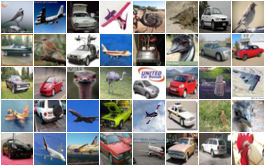

In [6]:
n_samples = 40
tensor2pil = transforms.ToPILImage()

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(image_datasets['train'], 
                                              batch_size = n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)
img_pil = tensor2pil(grid)
img_pil

## Teste inicial com pouquíssimas amostras

In [7]:
testing = True
if testing:
    n_samples = 800
    image_datasets['train'].train_data = image_datasets['train'].train_data[:n_samples]
    image_datasets['train'].train_labels = image_datasets['train'].train_labels[:n_samples]
    
    n_samples_test = 200
    image_datasets['val'].test_data = image_datasets['val'].test_data[:n_samples_test]
    image_datasets['val'].test_labels = image_datasets['val'].test_labels[:n_samples_test]

## Cria o DataLoader para os dados

In [8]:
batch_size = 100

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = batch_size,
                                         shuffle=True,  num_workers=4),
    'val'  : torch.utils.data.DataLoader(image_datasets['val'],   batch_size = batch_size,
                                         shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val'  : len(image_datasets['val'])
}

class_names = image_datasets['train'].classes

print('Tamanho do conjunto de treinamento:', dataset_sizes['train'])
print('Tamanho do conjunto de validacao:',   dataset_sizes['val'])
print('Classes:', class_names)

Tamanho do conjunto de treinamento: 800
Tamanho do conjunto de validacao: 200
Classes: ['airplane' 'automobile' 'bird']


# Construíndo a CNN com o PyTorch

<img src = '../figures/Rede_LeNet_Cifar.png', width=600pt></img>

In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d( 3, 32, kernel_size=3)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(32, 32, kernel_size=3)),
            ('relu2', nn.ReLU()),
            ('max_pool', nn.MaxPool2d(2)),
            ('drop', nn.Dropout(p=0.25))
        ]))
        
        # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(14*14*32, 128)),
            ('relu1',  nn.ReLU()),
            ('drop1',  nn.Dropout(p=0.5)),
            ('dense2', nn.Linear(128, 3)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 14*14*32)  # Transforma a imagem em vetor
        x = self.dense_layer(x)
        
        return x

In [10]:
model = MyModel()
if use_gpu:
    model = model.cuda()

model

MyModel(
  (conv_layer): Sequential(
    (conv1): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (drop): Dropout(p=0.25)
  )
  (dense_layer): Sequential(
    (dense1): Linear(in_features=6272, out_features=128)
    (relu1): ReLU()
    (drop1): Dropout(p=0.5)
    (dense2): Linear(in_features=128, out_features=3)
  )
)

## Testando o modelo com uma amostra

In [11]:
# imagem de entrada: 1 amostra, com 3 bandas (RGB), 32 linhas e 32 colunas
xin = Variable(torch.zeros(1, 3, 32, 32))

# predict da rede: saída 1 linha (amostra) com 3 colunas (scores),  (1 de cada classe)
yout = model(xin)

print('Saída:', yout.data.numpy())

Saída: [[ 0.01095111 -0.00750526 -0.04766026]]


## Treinamento da rede

In [12]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
savebest = ptt.ModelCheckpoint('../../models/cifar_cnn',reset=True, verbose=1)

# Cria o objeto para treinar a rede
trainer = ptt.DeepNetTrainer(
    model       = model,
    criterion   = criterion, 
    optimizer   = optimizer,
    callbacks   = [ptt.AccuracyMetric(),ptt.PrintCallback(),savebest]
)

In [13]:
trainer.fit_loader(5, train_data=dataloaders['train'], valid_data=dataloaders['val'])

Start training for 5 epochs
  1:   3.8s   T: 1.06510 0.37625   V: 0.98323 0.61000 best
  2:   3.5s   T: 0.93899 0.56625   V: 0.90195 0.62000 best
  3:   3.4s   T: 0.85938 0.63875   V: 0.89324 0.61000 best
  4:   3.4s   T: 0.78403 0.69625   V: 0.78850 0.67000 best
  5:   3.3s   T: 0.67966 0.71875   V: 0.73549 0.65500 best
Stop training at epoch: 5/5
Best model was saved at epoch 5 with loss 0.73549: ../../models/cifar_cnn


## Avaliação

### Gráfico da perda

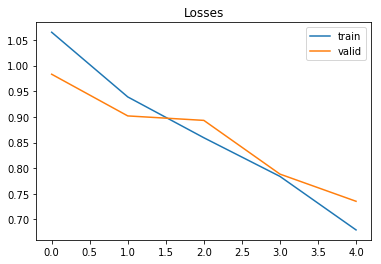

In [14]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, valid_loss, label='valid')
plt.legend()
plt.title('Losses')
plt.show()

### Gráfico da acurácia

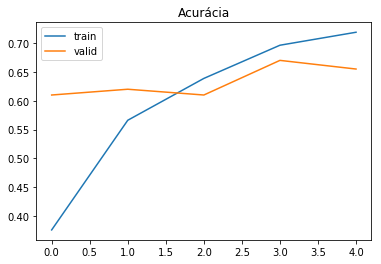

In [15]:
train_acc = trainer.metrics['train']['acc']
valid_acc = trainer.metrics['valid']['acc']
epochs = np.arange(len(train_acc))
plt.plot(epochs, train_acc, label='train')
plt.plot(epochs, valid_acc, label='valid')
plt.legend()
plt.title('Acurácia')
plt.show()

## Avaliação do treinamento no conjunto de testes

In [16]:
y_hat_v   = trainer.predict_classes_loader(dataloaders['val'])
y_hat = y_hat_v.numpy()

In [17]:
y_proba_v = trainer.predict_probas_loader(dataloaders['val']) # prob das classes
y_prob = y_proba_v.numpy().max(axis=1) # probabilidade máxima da classe

### Matriz de confusão

In [18]:
X_test = image_datasets['val'].test_data
y_test = np.array(image_datasets['val'].test_labels)
from pandas import crosstab
crosstab(y_test, y_hat)

col_0,0,1,2
row_0,,,
0,40,12,21
1,5,41,11
2,17,3,50


In [19]:
X_test.shape,y_test.shape

((200, 32, 32, 3), (200,))

## Predições certas com maior probabilidade

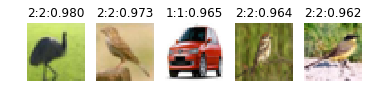

In [24]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]
fig, raxis = plt.subplots(1,5) 
for k,i in enumerate(y_top5):
    raxis[k].imshow(X_test[i])
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Predições certas com menor probabilidade

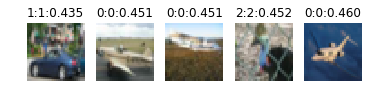

In [25]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
fig, raxis = plt.subplots(1,5) 
for k,i in enumerate(y_bot5):
    raxis[k].imshow(X_test[i])
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Predições erradas com maior probabilidade

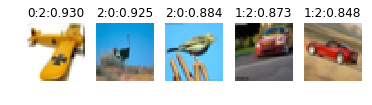

In [26]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]
fig, raxis = plt.subplots(1,5) 
for k,i in enumerate(y_most_not_ok_top5):
    raxis[k].imshow(X_test[i])
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Predições erradas com menor probabilidade

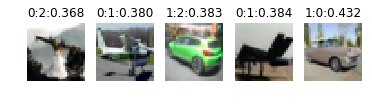

In [27]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]
fig, raxis = plt.subplots(1,5) 
for k,i in enumerate(y_least_not_ok_top5):
    raxis[k].imshow(X_test[i])
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Visualização de uma amostra

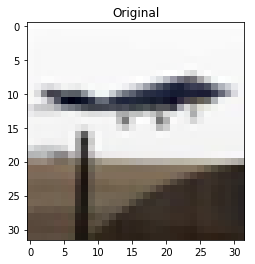

In [22]:
sample_number = 70  # amostra de número 70
plt.figure()
plt.imshow(X_test[sample_number])
#plt.axis('off')
plt.title("Original");

## Visualização das camadas internas

Observe que são 32 canais na primeira camada convolucional

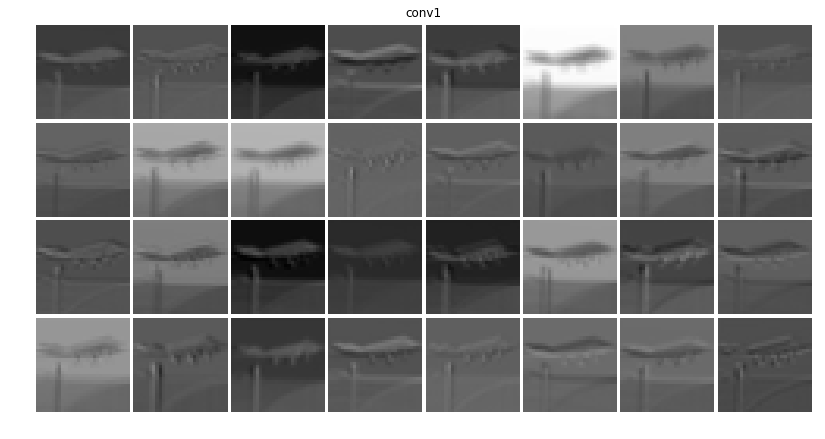

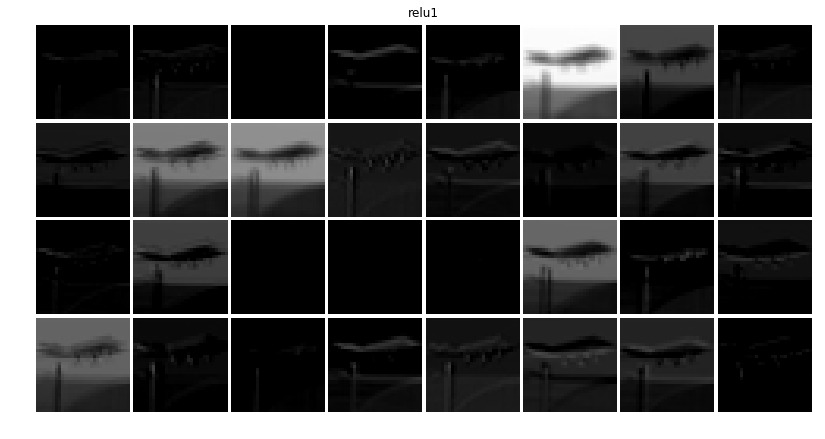

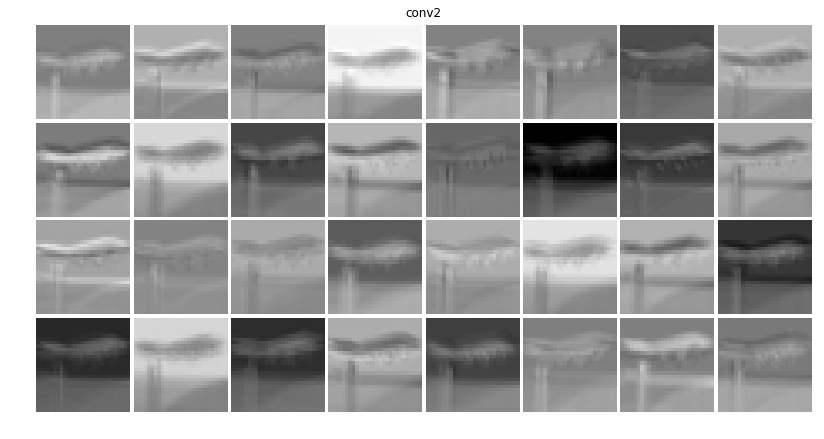

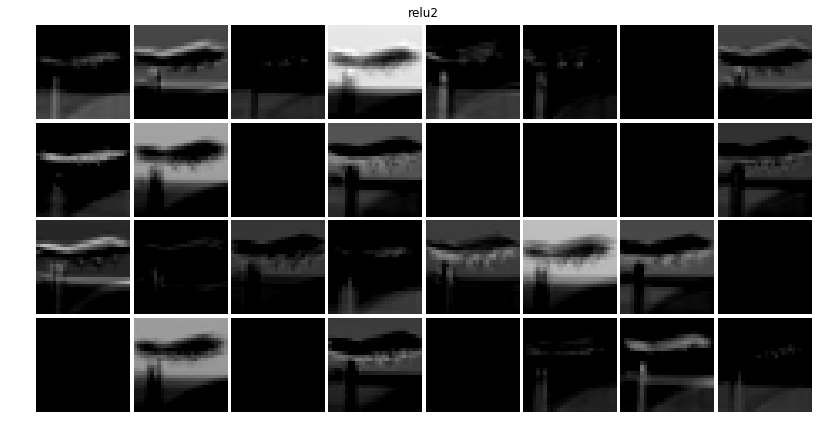

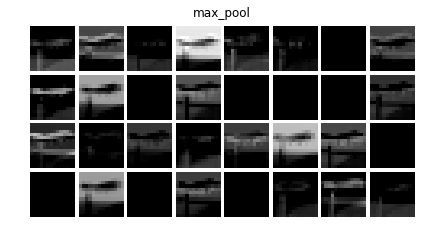

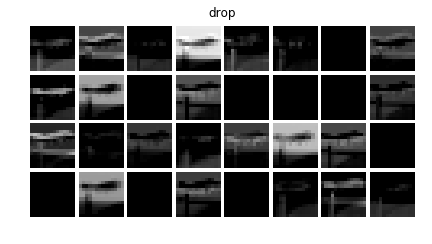

In [23]:
ncols = 8
H,W = 14,30

xin, _ = image_datasets['val'][sample_number]
xin = xin.view(1, 3, 32, 32)

x = Variable(xin)

model.train(mode=False) # qual é a diferença quando em modo treinamento ou avaliação?

#Mostrando a saida das camadas convolucionais
for name, layer in model.conv_layer.named_children():
    x = layer(x)
    
    grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                       pad_value=1.0, padding=1).numpy()
    
    if name == 'max_pool':
        H /= 2
        W /= 2
    fig = plt.figure(figsize=(H,W))
    plt.imshow(grid.transpose((1,2,0)))
    plt.title(name)
    plt.axis('off')
    plt.show()


## Exercícios

1. Quantos parâmetros são treinados nesta rede? Calcule o número de parâmetros de cada camada, não se esquecendo do *bias*.
2. Se as duas camadas convolucionais fossem densas, qual seria o número de parâmetros a serem treinados?

## Atividades

1. Troque a amostra que está sendo visualizada por outra
2. O que acontece na visualização dos valores nas camadas convolucionais, quando
   a rede é colocada no modo de treinamento ou no modo de avaliação? Faça o experimento
   e comprove.
3. Fazer uma função que calcule o número total de parâmetros de um objeto modelo de rede:
   ```
     def n_parameters(model):
        # calcula n. parâmetros
        return 
    ```

## Aprendizados com este experimento
1.